In [4]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.6 MB/s eta 0:00:00


In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle

In [17]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [19]:
# Step 1: Load the dataset
data = pd.read_csv("/content/drive/MyDrive/infosysSpringBoard/train.csv")
print("Dataset Loaded Successfully!")

Dataset Loaded Successfully!


In [20]:
# Step 2: Data Exploration
print("\nDataset Info:")
print(data.info())
print("\nDataset Description:")
print(data.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB
None

Dataset Description:
                 id         label
count  20800.000000  20800.000000
mean   10399.500000      0.500625
std     6004.587135      0.500012
min        0.000000      0.000000
25%     5199.750000      0.000000
50%    10399.500000      1.000000
75%    15599.250000      1.000000
max    20799.000000      1.000000


In [21]:
# Features of the dataset
print("\nDataset Columns: ", data.columns)


Dataset Columns:  Index(['id', 'title', 'author', 'text', 'label'], dtype='object')


In [22]:
# Display first few rows
print("\nFirst 5 Rows of Data:")
print(data.head())


First 5 Rows of Data:
   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


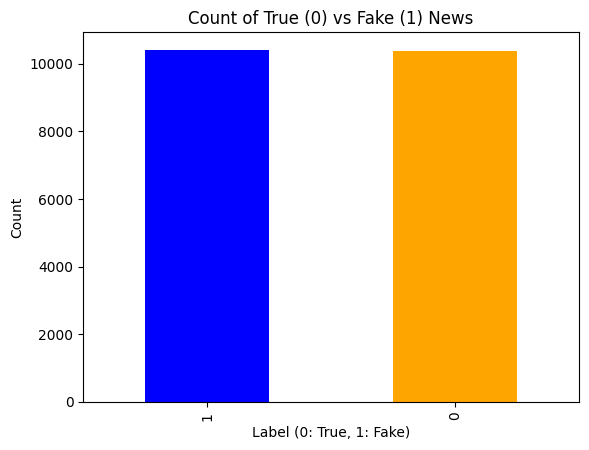

In [23]:
# Step 3: Histogram based on the type of data
data['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Count of True (0) vs Fake (1) News')
plt.xlabel('Label (0: True, 1: Fake)')
plt.ylabel('Count')
plt.show()

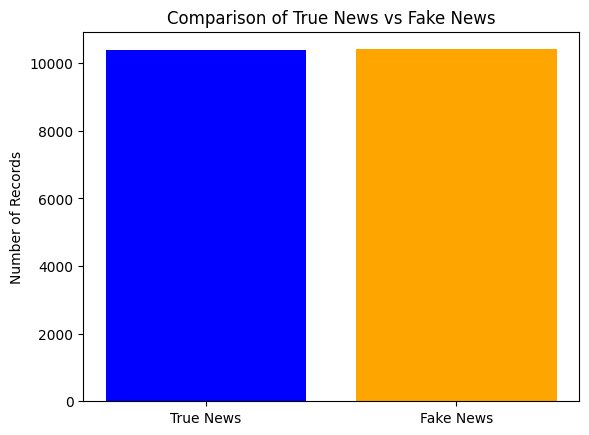

In [24]:
# Step 4: Comparing true news and fake news via bar graph
true_count = data[data['label'] == 0].shape[0]
fake_count = data[data['label'] == 1].shape[0]
plt.bar(['True News', 'Fake News'], [true_count, fake_count], color=['blue', 'orange'])
plt.title('Comparison of True News vs Fake News')
plt.ylabel('Number of Records')
plt.show()

In [25]:
# Step 5: Checking values for each column
print("\nChecking Value Counts for Each Column:")
for col in data.columns:
    print(f"\nColumn: {col}")
    print(data[col].value_counts())


Checking Value Counts for Each Column:

Column: id
id
0        1
13854    1
13872    1
13871    1
13870    1
        ..
6931     1
6930     1
6929     1
6928     1
20799    1
Name: count, Length: 20800, dtype: int64

Column: title
title
Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence              5
The Dark Agenda Behind Globalism And Open Borders                                                               5
Schools All Over America Are Closing On Election Day Due To Fears Of Violence                                   4
“If Trump Loses, I’m Grabbing My Musket”: Former Congressman Ready to Go Full Revolution                        4
Public vs. Media on War                                                                                         4
                                                                                                               ..
Report: Only 6% of Millennials Said Their Social Media Was a ’Completely True’

In [26]:
# Step 6: Data Cleaning
# Handling null values
print("\nChecking for Null Values:")
print(data.isnull().sum())
data = data.fillna('')


Checking for Null Values:
id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [27]:
# Checking for duplicates
print("\nChecking for Duplicates:")
duplicate_count = data.duplicated().sum()
print(f"Number of Duplicate Records: {duplicate_count}")
data = data.drop_duplicates()


Checking for Duplicates:
Number of Duplicate Records: 0


In [28]:
# Checking if data is balanced
print("\nChecking if Data is Balanced:")
print(data['label'].value_counts())


Checking if Data is Balanced:
label
1    10413
0    10387
Name: count, dtype: int64


In [29]:
# Step 7: Checking number of records between true and false news
print(f"\nNumber of True News: {true_count}")
print(f"Number of Fake News: {fake_count}")


Number of True News: 10387
Number of Fake News: 10413


In [30]:
# Step 8: Data Preprocessing
# Combine author, title, and text into one feature
data['content'] = data['author'] + " " + data['title'] + " " + data['text']

In [31]:
# Text cleaning
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    words = text.split()  # Tokenize
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize words
    return " ".join(words)

In [32]:
data['content'] = data['content'].apply(clean_text)
print("\nData Cleaning Completed!")


Data Cleaning Completed!


In [33]:
# Step 9: Tokenization and Removal of Punctuation/Stop Words
max_vocab_size = 5000
max_sequence_length = 500
embedding_dim = 100

In [34]:
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(data['content'].values)
X = tokenizer.texts_to_sequences(data['content'].values)
X = pad_sequences(X, maxlen=max_sequence_length, padding='post')

In [12]:
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=max_sequence_length, padding='post')

In [35]:
y = data['label'].values

In [36]:
# Save tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [37]:
# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [38]:
# Step 10: Defining Model with Hyperparameter Tuning
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=max_vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_sequence_length),
        LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
             return_sequences=True),
        Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)),
        LSTM(units=hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)),
        Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'),
        Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [39]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='fake_news_lstm'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [40]:
print("\nSearching for Best Hyperparameters...")
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=1)

Trial 10 Complete [00h 01m 45s]
val_accuracy: 0.9628205299377441

Best val_accuracy So Far: 0.965705156326294
Total elapsed time: 00h 20m 35s


In [41]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [42]:
# Build the model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)

In [43]:
# Step 11: Train the Model
batch_size = 64
epochs = 10
history = final_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, verbose=1)


Epoch 1/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5857 - loss: 0.6512 - val_accuracy: 0.6356 - val_loss: 0.5714
Epoch 2/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6629 - loss: 0.5591 - val_accuracy: 0.8109 - val_loss: 0.5041
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8285 - loss: 0.4001 - val_accuracy: 0.5862 - val_loss: 0.5501
Epoch 4/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8472 - loss: 0.3961 - val_accuracy: 0.8923 - val_loss: 0.3159
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8776 - loss: 0.3347 - val_accuracy: 0.6388 - val_loss: 0.5869
Epoch 6/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.7545 - loss: 0.4793 - val_accuracy: 0.8817 - val_loss: 0.3758
Epoch 7/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9097 - loss: 0.3003 - val_accuracy: 0.9010 - val_loss: 0.3105
Epoch 8/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8920 - loss: 0.3413 - val_ac

In [44]:
# Step 12: Evaluate on Unseen Data
y_pred = (final_model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy on Unseen Data: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

Test Accuracy on Unseen Data: 92.44%

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1560
           1       0.92      0.93      0.92      1560

    accuracy                           0.92      3120
   macro avg       0.92      0.92      0.92      3120
weighted avg       0.92      0.92      0.92      3120



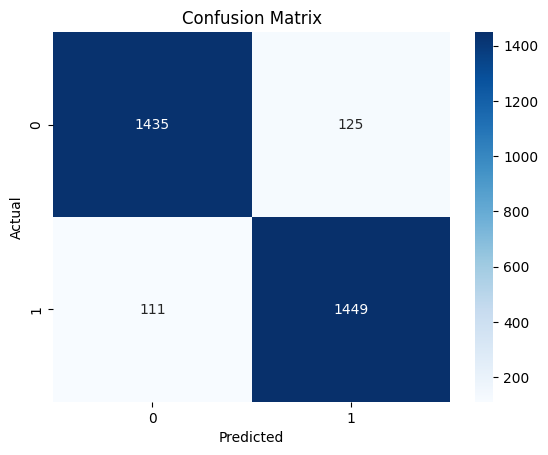

In [45]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [46]:
# Step 13: Save the Model
final_model.save("fake_news_model.h5")
print("\nModel Saved Successfully!")


Model Saved Successfully!


In [47]:
import matplotlib.pyplot as plt

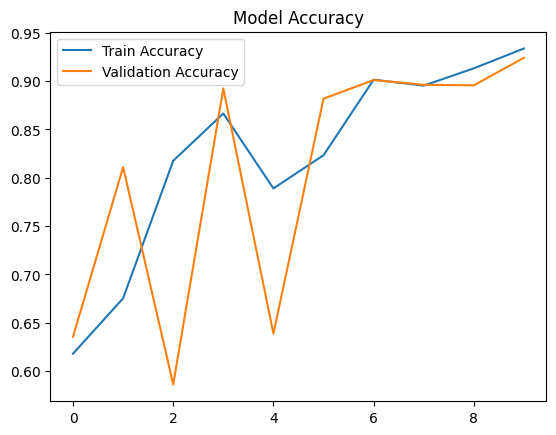

In [48]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.legend()
plt.show()

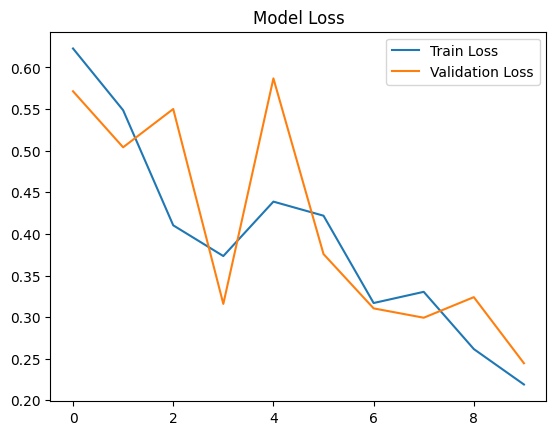

In [49]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.legend()
plt.show()

In [51]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

# Define maximum vocabulary size
max_vocab_size = 5000

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(data['content'].values)

# Save the tokenizer to a .pkl file
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle)

print("Tokenizer has been saved as 'tokenizer.pkl'")


Tokenizer has been saved as 'tokenizer.pkl'


In [53]:
# Load the tokenizer
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Use the tokenizer to preprocess new data
new_texts = ["India is 2nd lagest country"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_sequences_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post')

print("Tokenized and padded new data:")
print(new_sequences_padded)

Tokenized and padded new data:
[[1309   22    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  

In [60]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

# Load the trained model
final_model = load_model("fake_news_model.h5")

# Recompile the model for inference without metrics if not needed
final_model.compile(optimizer='adam', loss='binary_crossentropy')

# Preprocess the input text
def preprocess_input_text(text, tokenizer, max_sequence_length):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
    return padded_sequences

# Example input text
new_texts = ["India is 2nd largest country"]

# Preprocess the input
max_sequence_length = 500  # Same value used during training
processed_text = preprocess_input_text(new_texts[0], tokenizer, max_sequence_length)

# Predict the class for the processed text
predicted_label = (final_model.predict(processed_text, batch_size=1) > 0.5).astype("int32")
print("Prediction (0: Reliable, 1: Fake):", predicted_label[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Prediction (0: Reliable, 1: Fake): 1


In [58]:
# Step 13: Save the Model
final_model.save("fake_news_model.h5")
print("\nModel Saved Successfully!")


Model Saved Successfully!
